In [ ]:
!pip install memory_profiler


In [ ]:
!pip install imbalanced-learn


In [ ]:
# Loading neccesary libraries:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import re
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, make_scorer, f1_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import time
from memory_profiler import memory_usage




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/HateDetector/labeled_data.csv')
#Print that data imported successfully
print("Data imported successfully")
data.drop('Unnamed: 0', axis=1, inplace=True)
data.shape



Data imported successfully


(24783, 6)

#Visualization

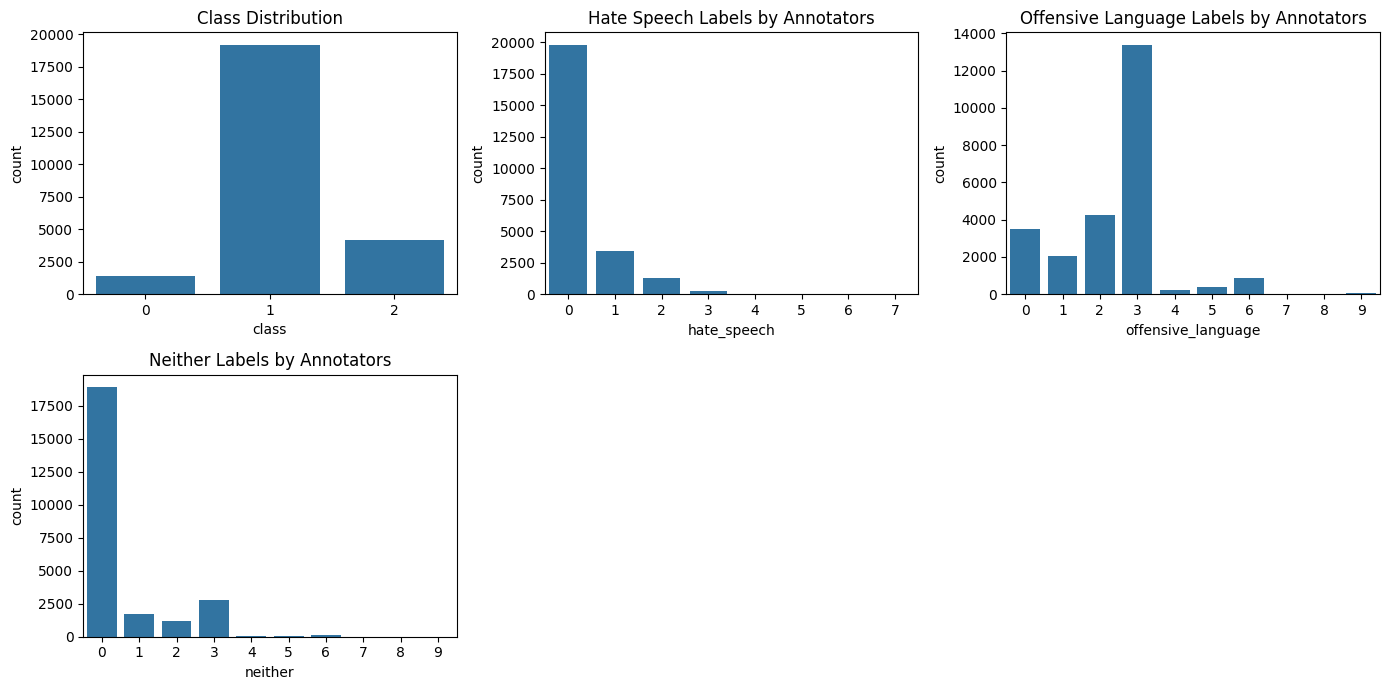

In [ ]:
# Setting up the matplotlib figure
plt.figure(figsize=(14, 7))

#  distribution of classes
plt.subplot(2, 3, 1)
sns.countplot(data=data,x='class' )
plt.title('Class Distribution')

#  hate speech
plt.subplot(2, 3, 2)
sns.countplot(x='hate_speech', data=data)
plt.title('Hate Speech Labels by Annotators')

#  offensive language
plt.subplot(2, 3, 3)
sns.countplot(x='offensive_language', data=data)
plt.title('Offensive Language Labels by Annotators')

#  neither
plt.subplot(2, 3, 4)
sns.countplot(x='neither', data=data)
plt.title('Neither Labels by Annotators')


# Adjust the layout
plt.tight_layout()
plt.show()


#Reflection
The plot shows us the number or frquency of tweets classified as hate,offensive,neither by annotators.
As we can clearly observe that there is an imbalance in our datset.The number of tweets classfied as Offensive is way more than hate and neither.Therefore we need to address this imbalance while training the model.

#Pre-processing of Data

In [ ]:
from collections import Counter
import re
# drop the 'Unnamed: 0' column as it's just an identifier and not useful for modeling.
data.drop('Unnamed: 0', axis=1, inplace=True)


# Function to clean and tokenize tweets
def clean_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, handles, and the hashtag symbol
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize by splitting on whitespace
    tokens = text.split()
    return tokens

# Apply the function to each tweet
data['tokens'] = data['tweet'].apply(clean_tokenize)

# Flatten all the token lists into a single list and count the occurrences
all_words = [word for tokens in data['tokens'] for word in tokens]
word_counts = Counter(all_words)

# Remove common English stop words and Twitter-related terms (including 'rt' for retweet)
stop_words = set(['a', 'i', 'the', 'you', 'to', 't', 'and', 'rt','my',])
filtered_words = {word: count for word, count in word_counts.items() if word not in stop_words}

# Now we have a filtered list of words, we can look for offensive words
# We will check the most common words and manually identify offensive words

# Display the most common words that are not in the stop words list
common_words = Counter(filtered_words).most_common(50)
common_words


[('bitch', 8237),
 ('that', 3527),
 ('bitches', 3084),
 ('in', 3052),
 ('is', 2912),
 ('like', 2771),
 ('me', 2735),
 ('of', 2549),
 ('on', 2528),
 ('be', 2377),
 ('hoes', 2369),
 ('this', 2153),
 ('for', 2119),
 ('pussy', 2108),
 ('im', 2090),
 ('it', 1937),
 ('hoe', 1910),
 ('with', 1848),
 ('dont', 1781),
 ('ass', 1570),
 ('your', 1542),
 ('up', 1514),
 ('all', 1509),
 ('if', 1504),
 ('just', 1462),
 ('but', 1459),
 ('get', 1430),
 ('fuck', 1414),
 ('so', 1404),
 ('they', 1354),
 ('when', 1323),
 ('these', 1316),
 ('no', 1309),
 ('got', 1290),
 ('u', 1282),
 ('shit', 1264),
 ('nigga', 1199),
 ('not', 1174),
 ('aint', 1169),
 ('was', 1155),
 ('are', 1150),
 ('trash', 1144),
 ('she', 1144),
 ('her', 1135),
 ('at', 1107),
 ('lol', 1068),
 ('out', 1066),
 ('have', 1046),
 ('its', 976),
 ('about', 922)]

In [ ]:
from collections import Counter
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')


# Update the function to include tokenization, removal of stop words, and stemming
def clean_tokenize_stem(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, handles, and the hashtag symbol
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize by splitting on whitespace
    tokens = word_tokenize(text)
    # Load stop words from NLTK
    stop_words = set(stopwords.words('english'))
    # Initialize the Porter Stemmer
    porter = PorterStemmer()
    # Filter out stop words and apply stemming
    filtered_stemmed_tokens = [porter.stem(word) for word in tokens if word not in stop_words]
    return filtered_stemmed_tokens

# Apply the updated function to each tweet
data['tokens'] = data['tweet'].apply(clean_tokenize_stem)

# Flatten all the token lists into a single list and count the occurrences
all_words = [word for tokens in data['tokens'] for word in tokens]
word_counts = Counter(all_words)

# Assuming you want to remove extremely common or Twitter-specific terms programmatically this time
additional_stop_words = {'rt'}  # You can add more Twitter-specific stop words here
filtered_words = {word: count for word, count in word_counts.items() if word not in additional_stop_words}

# Display the most common words that are not in the additional stop words list
common_words = Counter(filtered_words).most_common(20)
common_words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('bitch', 11336),
 ('hoe', 4283),
 ('like', 2855),
 ('fuck', 2251),
 ('pussi', 2217),
 ('im', 2090),
 ('nigga', 1991),
 ('dont', 1784),
 ('get', 1777),
 ('got', 1610),
 ('ass', 1587),
 ('shit', 1292),
 ('u', 1282),
 ('aint', 1169),
 ('trash', 1153),
 ('lol', 1068),
 ('go', 902),
 ('know', 880),
 ('amp', 845),
 ('love', 771)]

In [ ]:
data.head()

,count,hate_speech,offensive_language,neither,class,tweet,tokens
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[rt, woman, shouldnt, complain, clean, hous, a..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[rt, boy, dat, coldtyga, dwn, bad, cuffin, dat..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[rt, dawg, rt, ever, fuck, bitch, start, cri, ..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[rt, look, like, tranni]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[rt, shit, hear, might, true, might, faker, bi..."


As you can see we have dropped the unamed column.
Also we can also visualize how the tweet is tokenized.
Notice we need to further do pre-processing so as to extract only the useful tokens from the tweet.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['class'], test_size=0.2, random_state=42)

# Define the features (words) that we will calculate TF-IDF scores for
features = [
    'bitch', 'pussi', 'ass', 'shit', 'fuck', 'nigga',
    'dick', 'cunt', 'fag', 'hoes','hoe','bitches','trash'
]

# Initialize the TF-IDF Vectorizer with predefined vocabulary
tfidf_vectorizer = TfidfVectorizer(vocabulary=features)

# Fit the vectorizer on the training data
tfidf_vectorizer.fit(X_train)

# Transform both the training and test data
X_train = tfidf_vectorizer.transform(X_train)
X_test= tfidf_vectorizer.transform(X_test)

# Convert the TF-IDF matrices to DataFrames to visualize them better
tfidf_train_df = pd.DataFrame(X_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(X_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Now you have tfidf_train_df and tfidf_test_df to use in your model training and evaluation
tfidf_train_df.head()


,bitch,pussi,ass,shit,fuck,nigga,dick,cunt,fag,hoes,hoe,bitches,trash
0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.466636,0.0,0.000000,0.0,0.0,0.88445,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.489359,0.0,0.872082,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Model-1:Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import time

# Initialize Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {'max_depth': [10, 20, 30, 40, 50, None]}


# Initialize GridSearchCV
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy', verbose=1)

# Start timing
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# End timing
end_time = time.time()

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)
memory = memory_usage(max_usage=True)


# Output the results
training_time = end_time - start_time
best_params = grid_search.best_params_

print(f"Classification Report:\n{report}")
print(f"Training Time: {training_time} seconds")
print(f"Best Parameters: {best_params}")
print(f"Memory used: {memory} MiB")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.01      0.02       290
           1       0.80      0.99      0.88      3832
           2       0.71      0.18      0.29       835

    accuracy                           0.80      4957
   macro avg       0.59      0.39      0.40      4957
weighted avg       0.75      0.80      0.73      4957

Training Time: 1.4719278812408447 seconds
Best Parameters: {'max_depth': 10}
Memory used: 317.765625 MiB


#Model-2 And Model-3:Gaussian Naive Bayes & KNN

In [ ]:
nb = GaussianNB()
knn = KNeighborsClassifier()


#Using only training set






In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from memory_profiler import memory_usage

# Initializing classifiers
lr = LogisticRegression(max_iter=1000)
svm = SVC()

def evaluation(model, X, y, cv, scoring):
    start_time = time.time()
    mem_usage = memory_usage((cross_val_score, (model, X, y), {'cv': cv, 'scoring': scoring}), interval=0.1, max_usage=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    end_time = time.time()
    time_taken = end_time - start_time
    mean_acc = scores.mean()
    return mean_acc, time_taken, mem_usage

# Evaluating Logistic Regression
mean_acc_lr, time_lr, mem_lr = evaluation(lr, X_train, y_train, cv=2, scoring='accuracy')

# Evaluating SVM
mean_acc_svm, time_svm, mem_svm = evaluation(svm, X_train, y_train, cv=2, scoring='accuracy')

print(f"Logistic Regression - Accuracy: {mean_acc_lr}, Time: {time_lr} seconds, Memory: {mem_lr} MiB")
print(f"SVM - Accuracy: {mean_acc_svm}, Time: {time_svm} seconds, Memory: {mem_svm} MiB")


Logistic Regression - Accuracy: 0.792948653283567, Time: 1.6909434795379639 seconds, Memory: 321.83203125 MiB
SVM - Accuracy: 0.792898214465853, Time: 12.008751392364502 seconds, Memory: 417.08984375 MiB


#Hyperparameter Tuning

#Without using SMOTE and limiting the parameters to tune

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
nb = GaussianNB()
knn = KNeighborsClassifier()


# Define hyperparameters to tune
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Define scoring metrics
score_metrics = {'accuracy': 'accuracy',
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted'),
                   'f1': make_scorer(f1_score, average='weighted')}

# Instantiate GridSearchCV for KNN
g_search = GridSearchCV(knn, param_grid, cv=5, scoring=score_metrics, refit='f1')

# Fit the GridSearchCV instance to the training data
g_search.fit(X_train, y_train)

# Get the best hyperparameters
ideal_para = g_search.best_params_

# Get the best mean F1-score
ideal_mean_f1 = g_search.best_score_

(ideal_para, ideal_mean_f1)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


({'n_neighbors': 3}, 0.7289817811246821)

#Using Smote

In [ ]:

import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline # Import as ImPipeline to avoid confusion with sklearn's Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for converting sparse to dense
class DenseTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()




# scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}


smote = SMOTE(random_state=42)

# Create pipelines first oversample then run the classifier
pipeline_nb = ImPipeline([
    ('smote', smote),
    ('to_dense', DenseTransformer()),
    ('classifier', GaussianNB())
])
pipeline_knn = ImPipeline([
    ('smote', smote),
    ('to_dense', DenseTransformer()),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
])

# Performing cross-validation with the scoring metrics
cv_results_nb_smote = cross_validate(pipeline_nb, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=False,error_score='raise')
cv_results_knn_smote = cross_validate(pipeline_knn, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=False,error_score='raise')

# Calculating the mean scores across all folds for each classifier and each metric after addressing imbalance
mean_scores_nb_smote = {metric: np.mean(scores) for metric, scores in cv_results_nb_smote.items() if 'test_' in metric}
mean_scores_knn_smote = {metric: np.mean(scores) for metric, scores in cv_results_knn_smote.items() if 'test_' in metric}

(mean_scores_nb_smote, mean_scores_knn_smote)


({'test_accuracy': 0.7060427123615041,
  'test_precision': 0.8414325986121549,
  'test_recall': 0.7060427123615041,
  'test_f1': 0.7375133734264644},
 {'test_accuracy': 0.7800362984485402,
  'test_precision': 0.8176328462405804,
  'test_recall': 0.7800362984485402,
  'test_f1': 0.7717527654604798})

In [ ]:
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline # Import as ImPipeline to avoid confusion with sklearn's Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for converting sparse to dense (needed for GaussianNB with SMOTE)
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Create pipelines that first oversample with SMOTE and then apply the classifier
pipeline_nb = ImPipeline([
    ('smote', smote),  # SMOTE step for handling class imbalance
    ('to_dense', DenseTransformer()),  # Convert sparse matrix to dense, necessary for GaussianNB
    ('classifier', GaussianNB())  # The classifier
])

pipeline_knn = ImPipeline([
    ('smote', smote),  # SMOTE step for handling class imbalance
    # Note: For KNeighborsClassifier, converting to dense is not required
    ('classifier', KNeighborsClassifier())  # The classifier
])


# Define parameter grids: GaussianNB's parameter grid could be on var_smoothing, for KNN - n_neighbors, weights, and metric
param_grid_nb = {
    'classifier__var_smoothing': np.logspace(0, -9, num=10)
}
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Define multiple scoring metrics
scoring_metrics = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Setup GridSearchCV for each pipeline with multiple scoring metrics
grid_search_nb = GridSearchCV(pipeline_nb, param_grid_nb, scoring=scoring_metrics, refit='f1', cv=5, n_jobs=-1)
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, scoring=scoring_metrics, refit='f1', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_nb.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)

# Extract the best parameters and the best F1 score (since refit='f1')
best_params_nb = grid_search_nb.best_params_
best_f1_score_nb = grid_search_nb.best_score_
best_params_knn = grid_search_knn.best_params_
best_f1_score_knn = grid_search_knn.best_score_

# Display the best parameters and F1 scores for each classifier
(best_params_nb, best_f1_score_nb), (best_params_knn, best_f1_score_knn)


(({'classifier__var_smoothing': 0.001}, 0.7375511894300804),
 ({'classifier__metric': 'manhattan',
   'classifier__n_neighbors': 3,
   'classifier__weights': 'uniform'},
  0.7284335567989545))

#Using test set

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.base import BaseEstimator, TransformerMixin
import time
import numpy as np

# Assume X_train, y_train, X_test, y_test are available from the user's data

# Custom transformer for converting sparse to dense (needed for GaussianNB with SMOTE)
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

# Best parameters from the GridSearch output
best_params_nb = {'classifier__var_smoothing': 0.001}
best_params_knn = {
    'classifier__metric': 'manhattan',
    'classifier__n_neighbors': 3,
    'classifier__weights': 'uniform'
}

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize GaussianNB and KNeighborsClassifier with best parameters
gnb = GaussianNB(var_smoothing=best_params_nb['classifier__var_smoothing'])
knn = KNeighborsClassifier(n_neighbors=best_params_knn['classifier__n_neighbors'],
                           weights=best_params_knn['classifier__weights'],
                           metric=best_params_knn['classifier__metric'])

# Create pipelines with SMOTE and the classifiers with best parameters
pipeline_nb = ImPipeline([
    ('smote', smote),
    ('to_dense', DenseTransformer()),
    ('classifier', gnb)
])

pipeline_knn = ImPipeline([
    ('smote', smote),
    ('classifier', knn)
])

# Time and memory tracking for GaussianNB
start_time_nb = time.time()
pipeline_nb.fit(X_train, y_train)
predictions_nb = pipeline_nb.predict(X_test)
end_time_nb = time.time()
time_taken_nb = end_time_nb - start_time_nb
precision_nb = precision_score(y_test, predictions_nb, average='weighted')
recall_nb = recall_score(y_test, predictions_nb, average='weighted')
f1_nb = f1_score(y_test, predictions_nb, average='weighted')

# Time and memory tracking for KNeighborsClassifier
start_time_knn = time.time()
pipeline_knn.fit(X_train, y_train)
predictions_knn = pipeline_knn.predict(X_test)
end_time_knn = time.time()
time_taken_knn = end_time_knn - start_time_knn
precision_knn = precision_score(y_test, predictions_knn, average='weighted')
recall_knn = recall_score(y_test, predictions_knn, average='weighted')
f1_knn = f1_score(y_test, predictions_knn, average='weighted')

# Results - Time and scores for each classifier
results_nb = (time_taken_nb, precision_nb, recall_nb, f1_nb)
results_knn = (time_taken_knn, precision_knn, recall_knn, f1_knn)

results_nb, results_knn



((0.15520906448364258,
  0.8385631492090782,
  0.7012305830139197,
  0.7339717024624456),
 (13.891840696334839,
  0.8708823583190266,
  0.6856969941496873,
  0.7371002963104575))

#MileStone 3

SVC with using just one set of parameters(may not be optimized)

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

svm = SVC(C=1, gamma=0.01)


oversampler = RandomOverSampler(random_state=42)


pl_svm = Pipeline([('oversampler', oversampler), ('svm', svm)])


pl_svm.fit(X_train, y_train)


y_pred_svm = pl_svm.predict(X_test)


report_svm = classification_report(y_test, y_pred_svm, target_names=['Class 0', 'Class 1', 'Class 2'])

print(report_svm)



              precision    recall  f1-score   support

     Class 0       0.27      0.63      0.38       290
     Class 1       0.98      0.81      0.89      3832
     Class 2       0.72      0.95      0.82       835

    accuracy                           0.82      4957
   macro avg       0.65      0.79      0.69      4957
weighted avg       0.89      0.82      0.84      4957



In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, make_scorer, f1_score

svm = SVC()
oversampler = RandomOverSampler(random_state=42)
pl_svm = Pipeline([('oversampler', oversampler), ('svm', svm)])

# Defined the parameter grid for svm
para_grid = {
    'svm__C': [1, 10],
    'svm__gamma': [0.1, 1]
}

# score function
score = make_scorer(f1_score, average='weighted')

# Initialized GridSearchCV with pipeline and parameter grid
gsearch_svm = GridSearchCV(pl_svm, para_grid, scoring=score, cv=2, n_jobs=-1)


gsearch_svm.fit(X_train, y_train)

# best parameters and the corresponding score
ideal_para = gsearch_svm.best_params_
ideal_score = gsearch_svm.best_score_

# Used best estimator to make predictions

ideal_estimator = gsearch_svm.best_estimator_
y_pred = ideal_estimator.predict(X_test)


Findings = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])


print(f"Best Parameters: {ideal_para}")
print(f"Best Score: {ideal_score}")
print("Classification Report:")
print(Findings)




Best Parameters: {'svm__C': 1, 'svm__gamma': 1}
Best Score: 0.8899012078040754
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.38      0.39      0.38       290
     Class 1       0.95      0.91      0.93      3832
     Class 2       0.78      0.94      0.85       835

    accuracy                           0.88      4957
   macro avg       0.70      0.74      0.72      4957
weighted avg       0.89      0.88      0.89      4957

Elapsed time: 1945.8981931209564 seconds
Memory used: 1321.0625 MiB


# Using best parameter

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

svm = SVC(C=1, gamma=1)
#The higher the gamma value, the more it tries to exactly fit the training data set

# Define the oversampling strategy
oversampler = RandomOverSampler(random_state=42)

# Create the pipeline
pl_svm = Pipeline([('oversampler', oversampler), ('svm', svm)])
start_time = time.time()

# Fit the pipeline to the training data
pl_svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred_svm = pl_svm.predict(X_test)
end_time = time.time()
memory = memory_usage(max_usage=True)


# Generate the classification report
report_svm = classification_report(y_test, y_pred_svm, target_names=['Class 0', 'Class 1', 'Class 2'])
elapsed_time = end_time - start_time

print(report_svm)
print(f"Elapsed time: {elapsed_time} seconds")
print(f"Memory used: {memory} MiB")


              precision    recall  f1-score   support

     Class 0       0.16      0.19      0.17       290
     Class 1       0.97      0.81      0.88      3832
     Class 2       0.57      0.98      0.72       835

    accuracy                           0.80      4957
   macro avg       0.57      0.66      0.59      4957
weighted avg       0.86      0.80      0.81      4957

Elapsed time: 24.795989513397217 seconds
Memory used: 432.05078125 MiB


# Logistic Regression

In [ ]:
# Define the classifier and parameters for hyperparameter tuning
lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
parameters = {
    'logistic_reg__C': [0.01, 0.1, 1, 10, 100],
    'logistic_reg__penalty': ['l2']  # 'lbfgs' solver supports only 'l2' or 'none' penalties
}

# Oversampling
oversampler = RandomOverSampler(random_state=42)
pl_lr = Pipeline([('oversampler', oversampler), ('logistic_reg', lr)])

#  Scorung metric based on F1 score
f1_score = make_scorer(f1_score, average='weighted')

# Setting up the GridSearchCV
g_search = GridSearchCV(pl_lr, parameters, scoring=f1_score, cv=5)

# Fit the GridSearchCV to find the best parameters
g_search.fit(X_train, y_train)

# Ideal parameters and score
ideal_para = g_search.best_params_
ideal_score = g_search.best_score_

# Using ideal values  to make predictions on the test set
ideal_lr = g_search.best_estimator_
y_pred_lr = ideal_lr.predict(X_test)


lr_report = classification_report(y_test, y_pred_lr, target_names=['Class 0', 'Class 1', 'Class 2'])

(ideal_para, ideal_score, lr_report)



({'logistic_reg__C': 10, 'logistic_reg__penalty': 'l2'},
 0.8089131350779717,
 '              precision    recall  f1-score   support\n\n     Class 0       0.16      0.21      0.18       290\n     Class 1       0.98      0.80      0.88      3832\n     Class 2       0.57      0.98      0.72       835\n\n    accuracy                           0.80      4957\n   macro avg       0.57      0.66      0.59      4957\nweighted avg       0.86      0.80      0.81      4957\n')

# Logistic Regression Using optimized parameters


In [ ]:
lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000)#Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm
#The 'l2' penalty is the sum of the square of the coefficients This type of penalty encourages the model coefficients to be small
#maximum number of iterations taken for the solvers to converge
oversampler = RandomOverSampler(random_state=42)

# Create the pipeline
pl_lr = Pipeline([('oversampler', oversampler), ('logistic_reg', lr)])

start_time = time.time()

# Fit the pipeline to the training data
pl_lr.fit(X_train, y_train)

# Making predictions on the test data
y_pred_lr = pl_lr.predict(X_test)

end_time = time.time()
memory = memory_usage(max_usage=True)


report_lr = classification_report(y_test, y_pred_lr, target_names=['Class 0', 'Class 1', 'Class 2'])
elapsed_time = end_time - start_time

print(report_lr)
print(f"Elapsed time: {elapsed_time} seconds")
print(f"Memory used: {memory} MiB")


Predicted Category: Hate Speech
              precision    recall  f1-score   support

     Class 0       0.16      0.21      0.18       290
     Class 1       0.98      0.80      0.88      3832
     Class 2       0.57      0.98      0.72       835

    accuracy                           0.80      4957
   macro avg       0.57      0.66      0.59      4957
weighted avg       0.86      0.80      0.81      4957

Elapsed time: 0.5731353759765625 seconds
Memory used: 372.30859375 MiB


# **Tried doing both in one go didnt work**

In [ ]:
#both combined
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline


svc = SVC()
lr = LogisticRegression()


scores = {'f1': make_scorer(f1_score, average='weighted')}


parameters_svc = {'svc__C': [0.1, 1],
                  'svc__gamma': [0.1, 0.01]}
parameters_lr = {'logistic_reg__C': [0.1, 1],
                  'logistic_reg__penalty': ['l1', 'l2']}

oversampler = RandomOverSampler()


pl_svc = Pipeline([('oversampler', oversampler), ('svc', svc)])
pl_lr = Pipeline([('oversampler', oversampler), ('logistic_reg', lr)])


gsearch_svc = GridSearchCV(pl_svc, parameters_svc, scoring=scores, refit='f1')
gsearch_lr = GridSearchCV(pl_lr, parameters_lr, scoring=scores, refit='f1')

gsearch_svc.fit(X_train, y_train)
gsearch_lr.fit(X_train, y_train)


idealpara_svc = gsearch_svc.best_params_
idealpara_lr = gsearch_lr.best_params_
idealf1_svc = gsearch_svc.best_score_
idealf1_lr = gsearch_lr.best_score_

(idealpara_svc, idealpara_lr, idealf1_svc, idealf1_lr)
